Khai thác dữ liệu văn bản và ứng dụng - 21CNTThuc

Group 01

|HỌ VÀ TÊN   | MSSV  |
|---|---|
|Bùi Tấn Phương|  20127597 |
|Trần Quốc Trung   |20127655   |
|Hoàng Phước Nguyên   |20127258   |
|Nguyễn Trương Hoàng Thái   |20127625   |

# Model: VoVanPhuc/sup-SimCSE-VietNamese-phobert-base

* Tên mô hình (supervised version): [VoVanPhuc/sup-SimCSE-VietNamese-phobert-base](https://huggingface.co/VoVanPhuc/sup-SimCSE-VietNamese-phobert-base)
* Lý do lựa chọn mô hình: mô hình hỗ trợ Tiếng Việt cho Sentence Similarity (mô hình từ năm 2020 trở đi), đủ nhẹ để train trên colab và mô hình có thể sử dụng với API của HF.
* Mô hình đc sử dụng thông qua API `sentence_transformers` của hugging face (khác với API transformers). Code được hỗ trợ bởi MS Copilot.
* Tóm tắt mô hình: mô hình sử dụng phương thức train của [SimCSE (2021)](https://doi.org/10.48550/arXiv.2104.08821) và pre-trained model [PhoBert (2020)](https://aclanthology.org/2020.findings-emnlp.92/) cho quá trình encode.

### 1. Import library

In [ ]:
!pip install -U sentence_transformers
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 72.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import string
import regex as re
import matplotlib.pyplot as plt
import time

from sentence_transformers import SentenceTransformer, InputExample, losses, util
from torch.utils.data import DataLoader, IterableDataset
from pyvi.ViTokenizer import tokenize
import torch
import unicodedata
from pyvi import ViTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

### 2. Test on pre-trained model with cosine similarity

In [ ]:
# Load pre-trained model and create example data
model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
sentences = ["Quang Hải giành được chức vô địch U21 quốc gia năm bao nhiêu tuổi", "Anh bắt đầu gia nhập lò đào tạo trẻ Hà Nội T&T khi mới 9 tuổi vào năm 2006 ."]
sentences = [tokenize(sentence) for sentence in sentences]

# Encode data
embeddings = model.encode(sentences)

# Compute similarity scores for all sentence pairs
similarity_matrix = cosine_similarity(embeddings)

# Similarity score between the first and second sentences
similarity_score = similarity_matrix[0][1]
print(f"Similarity score between sentence 1 and sentence 2: {similarity_score:.4f}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/542M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Similarity score between sentence 1 and sentence 2: 0.2563


### 3. Fine-tuning (retrain)

#### Read data

In [ ]:
# Download data
!wget https://raw.githubusercontent.com/Thaifitus/data_storage/master/data_sentence_similarity.json
# Download stopword list
!wget https://raw.githubusercontent.com/Thaifitus/data_storage/master/vietnamese-stopwords.txt

--2024-03-08 00:39:48--  https://raw.githubusercontent.com/Thaifitus/NLP-CSC15006_21CNTThuc/master/Project1_Data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10417553 (9.9M) [text/plain]
Saving to: ‘Project1_Data.json’

Project1_Data.json  100%[===================>]   9.93M  --.-KB/s    in 0.1s    

2024-03-08 00:39:49 (78.8 MB/s) - ‘Project1_Data.json’ saved [10417553/10417553]

--2024-03-08 00:39:49--  https://raw.githubusercontent.com/Thaifitus/NLP-CSC15006_21CNTThuc/master/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting 

In [ ]:
# Mount drive and cd to directory
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/Colab\ Notebooks

In [ ]:
df = pd.read_json('data_sentence_similarity.json')
# Just take 3 columns from original dataset
new_df = df[['question','text', 'label']]

new_df.shape

(18108, 3)

#### Pre-processing

In [ ]:
char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|\
            ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|\
            À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|\
            Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split('|')

charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|\
            ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|\
            À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|\
            Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split('|')

unicode_dict = zip(char1252, charutf8)

bang_nguyen_am = [['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a'],
                  ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
                  ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
                  ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e'],
                  ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
                  ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i'],
                  ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o'],
                  ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
                  ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
                  ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u'],
                  ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
                  ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y']]

nguyen_am_to_ids = {}

for i in range(len(bang_nguyen_am)):
    for j in range(len(bang_nguyen_am[i]) - 1):
        nguyen_am_to_ids[bang_nguyen_am[i][j]] = (i, j)

In [ ]:
def clean_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean the dataframe
    """
    # Remove duplicate rows
    df = df.drop_duplicates()

    # Remove missing values
    df = df[df['question'] != '']
    df = df[df['text'] != '']

    return df

def standaridize_unicode(text: str) -> str:
    """
    Transform text to its standardized form
    """
    text = unicodedata.normalize('NFC', text)
    return text

def is_valid_vietnam_word(word: str) -> bool:
    """
    Check if a word is a valid Vietnamese word
    """
    chars = list(word)
    nguyen_am_index = -1
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x != -1:
            if nguyen_am_index == -1:
                nguyen_am_index = index
            else:
                if index - nguyen_am_index != 1:
                    return False
                nguyen_am_index = index
    return True

def standardize_vietnameseStyle_word(word: str) -> str:
    """
    Standardize Vietnamese word
    """
    if not is_valid_vietnam_word(word):
        return word

    chars = list(word)
    dau_cau = 0
    nguyen_am_index = []
    qu_or_gi = False
    for index, char in enumerate(chars):
        x, y = nguyen_am_to_ids.get(char, (-1, -1))
        if x == -1:
            continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True
        if y != 0:
            dau_cau = y
            chars[index] = bang_nguyen_am[x][0]
        if not qu_or_gi or index != 1:
            nguyen_am_index.append(index)
    if len(nguyen_am_index) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = nguyen_am_to_ids.get(chars[1])
                chars[1] = bang_nguyen_am[x][dau_cau]
            else:
                x, y = nguyen_am_to_ids.get(chars[2], (-1, -1))
                if x != -1:
                    chars[2] = bang_nguyen_am[x][dau_cau]
                else:
                    chars[1] = bang_nguyen_am[5][dau_cau] if chars[1] == 'i' else bang_nguyen_am[9][dau_cau]
            return ''.join(chars)
        return word

    for index in nguyen_am_index:
        x, y = nguyen_am_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = bang_nguyen_am[x][dau_cau]
            return ''.join(chars)

    if len(nguyen_am_index) == 2:
        if nguyen_am_index[-1] == len(chars) - 1:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[0]]]
            chars[nguyen_am_index[0]] = bang_nguyen_am[x][dau_cau]
        else:
            x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
            chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    else:
        x, y = nguyen_am_to_ids[chars[nguyen_am_index[1]]]
        chars[nguyen_am_index[1]] = bang_nguyen_am[x][dau_cau]
    return ''.join(chars)

def standardize_vietnameseStyle_sentence(sentence: str) -> str:
    """
    Standardize Vietnamese sentence
    """

    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        # print(cw)
        if len(cw) == 3:
            cw[1] = standardize_vietnameseStyle_word(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)


def remove_special_characters(text: str) -> str:
    """
    Remove special characters from the text
    """
    text = re.sub(r'\s+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def remove_stopwords(text: str) -> str:
    """
    Remove stopwords from the text
    """
    with open('vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
        stopwords = set([w.strip() for w in f.readlines()])

    words = ViTokenizer.tokenize(text).split()
    words = [word for word in words if word not in stopwords]
    return ' '.join(words)

def lower_case(text: str) -> str:
    """
    Convert the text to lower case
    """
    return text.lower()


def preprocess_text(text: str) -> str:
    """
    Preprocess the text
    """
    standardUnicode = standaridize_unicode(text)
    standardVietnamese = standardize_vietnameseStyle_sentence(standardUnicode)
    text = remove_special_characters(standardVietnamese)
    text = remove_stopwords(text)
    text = lower_case(text)

    return text

In [ ]:
# Pre-process for new_df
new_df = clean_dataframe(new_df)
for text in ['question', 'text']:
    new_df[text] = new_df[text].apply(preprocess_text)
new_df['label'] = new_df['label'].astype(float) # convert "label" column from boolean to float for training

new_df.sample(5)

,question,text,label
3585,dụng_cụ storm glass phát_minh,xếp áp_kế storm glass,0.0
12003,thành thăng long gọi,1010 tương_truyền vua lý công uẩn rời kinh đô ...,1.0
4197,việt nam bao_nhiêu dân_tộc,hiện_nay việt nam 54 dân_tộc 1 nước_ngoài nêu ...,1.0
2581,hàn_mạc tử sinh mấy,hàn mặc tử hàn_mạc tử nguyễn trọng trí sinh 22...,1.0
5499,estonia giáp biển,đất_liền estonia đường_biên_giới hai liên_bang...,0.0


In [ ]:
new_df.shape

(18056, 3)

#### Fine-tune process

In [ ]:
def re_train(model, data_in, test_ratio, shuffle, batch_size, epoch):
  '''
  (pre-trained model, pandas.DataFrame, float, bool, int, int) -> (pandas.DataFrame)

  Description:
    Retrain the VoVanPhuc/sup-SimCSE-VietNamese-phobert-base using sentence_transformers API with given config. The loaded model is configured OUTSIDE function and
    train/test process is configured INSIDE this function.
    Return the evaluation result "results" which has [accuracy, recall, precision, f1-score] values.

  Example:
  # Initialize example data from first 100 sentence
  >>> temp_data = new_df.iloc[0:20, :]
  # Model evaluation
  >>> model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
  >>> temp = re_train(model, temp_data, test_ratio=0.4, shuffle=True, batch_size=32, epoch=4) # 12 train, 8 test
  '''

  start_time = time.time() # time count starting
  # TRAIN
  # Split data
  data_train, data_test = train_test_split(data_in, test_size=test_ratio, random_state=42) # shape=(n', 3)
  # Prepare the training data
  dataset_train = [InputExample(texts=[row["question"], row["text"]], label=row["label"]) for index, row in data_train.iterrows()]
  dataloader = DataLoader(dataset_train, shuffle=shuffle, batch_size=batch_size)
  # Define the training procedure
  train_loss = losses.CosineSimilarityLoss(model)
  # Retrain the model
  model.fit(train_objectives=[(dataloader, train_loss)], epochs=epoch, warmup_steps=100)


  # TEST
  # 1. Compute embeddings
  question_embeddings = model.encode(data_test['question'].tolist())#, convert_to_tensor=True)
  text_embeddings = model.encode(data_test['text'].tolist())#, convert_to_tensor=True)
  # 2. Compute cosine similarity matrix and Take diagonals similarity
  cos_sim = cosine_similarity(question_embeddings, text_embeddings)
  cos_sim = cos_sim.diagonal()
  cos_sim = cos_sim.tolist()
  # 3. Convert cosine similarity to binary with threshold > 0.5 as similar
  predictions = [1.0 if x > 0.5 else 0.0 for x in cos_sim]

  total_time = time.time() - start_time # time count ending
  # 4. Compute metrics
  accuracy = accuracy_score(data_test['label'], predictions)
  recall = recall_score(data_test['label'], predictions)
  precision = precision_score(data_test['label'], predictions)
  f1 = f1_score(data_test['label'], predictions)
  # Create a DataFrame with the results
  results = pd.DataFrame({
    'Process time':[total_time],
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1-score': [f1]
    })

  return results

### 4. Survey model

In [ ]:
def plot_survey(survey_df, x_col, y1_col, y2_col):
    '''
    (pandas.DataFrame, string, string, string) -> figure

    Description: based on axises' name x_col, y1_col, y2_col, visualizing data in survey_df using matplotlib.pyplot library.
    '''

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(survey_df[x_col], survey_df[y1_col], c='green')
    ax1.set_ylabel(y1_col, color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.tick_params(axis='x', labelrotation=45)
    ax1.set_xlabel(x_col)

    ax2.plot(survey_df[x_col], survey_df[y2_col], c='blue')
    ax2.set_ylabel(y2_col, color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    ax2.set_xticks(survey_df[x_col])

    fig.tight_layout()
    plt.show();

#### test_ratio

In [ ]:
# Initialize survey list and result dataframe
test_ratio_in = [0.1, 0.3, 0.4, 0.6, 0.8]
result_df = pd.DataFrame({
    'test_ratio': [],
    'Process time': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-score': []
    })

# Model evaluation
for test_ratio_i in test_ratio_in:
  # Load pre-trained model
  model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
  # Survey model and return dataframe
  temp_df = re_train(model, new_df, test_ratio=test_ratio_i, shuffle=True, batch_size=32, epoch=5)
  # Append new data to result_df
  result_df = pd.concat([result_df, temp_df], axis=0, ignore_index=True)

result_df['test_ratio'] = test_ratio_in

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/508 [00:00<?, ?it/s]

Iteration:   0%|          | 0/508 [00:00<?, ?it/s]

Iteration:   0%|          | 0/508 [00:00<?, ?it/s]

Iteration:   0%|          | 0/508 [00:00<?, ?it/s]

Iteration:   0%|          | 0/508 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/395 [00:00<?, ?it/s]

Iteration:   0%|          | 0/395 [00:00<?, ?it/s]

Iteration:   0%|          | 0/395 [00:00<?, ?it/s]

Iteration:   0%|          | 0/395 [00:00<?, ?it/s]

Iteration:   0%|          | 0/395 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/226 [00:00<?, ?it/s]

Iteration:   0%|          | 0/226 [00:00<?, ?it/s]

Iteration:   0%|          | 0/226 [00:00<?, ?it/s]

Iteration:   0%|          | 0/226 [00:00<?, ?it/s]

Iteration:   0%|          | 0/226 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/113 [00:00<?, ?it/s]

Iteration:   0%|          | 0/113 [00:00<?, ?it/s]

Iteration:   0%|          | 0/113 [00:00<?, ?it/s]

Iteration:   0%|          | 0/113 [00:00<?, ?it/s]

Iteration:   0%|          | 0/113 [00:00<?, ?it/s]

   test_ratio  Process time  Accuracy    Recall  Precision  F1-score
0         0.1   1879.588830  0.784053  0.517241   0.731707  0.606061
1         0.3   1490.133618  0.773675  0.510133   0.698652  0.589692
2         0.4   1290.562403  0.771148  0.504161   0.688397  0.582048
3         0.6    866.678664  0.752077  0.454334   0.658516  0.537694
4         0.8    471.967292  0.738733  0.377096   0.654820  0.478585


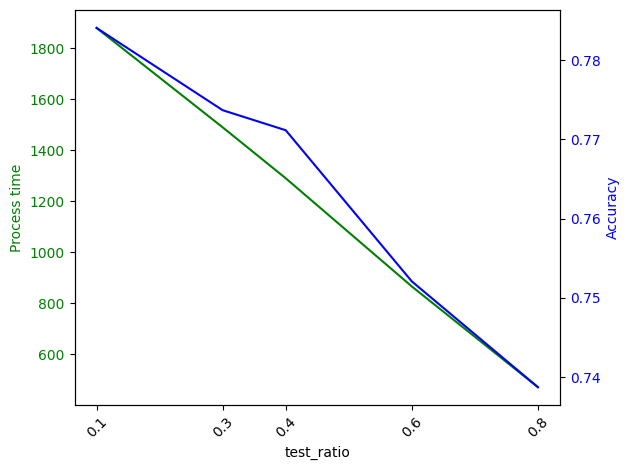

In [ ]:
# Print out and plot result dataframe
print(result_df)
plot_survey(result_df, 'test_ratio', 'Process time', 'Accuracy')

#### batch_size

In [ ]:
# Initialize survey list and result dataframe
batch_size_in = [8, 16, 32]
result_df = pd.DataFrame({
    'batch_size': [],
    'Process time': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-score': []
    })

# Model evaluation
for batch_size_i in batch_size_in:
  # Load pre-trained model
  model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
  # Survey model and return dataframe
  temp_df = re_train(model, new_df, test_ratio=0.4, shuffle=True, batch_size=batch_size_i, epoch=5)
  # Append new data to result_df
  result_df = pd.concat([result_df, temp_df], axis=0, ignore_index=True)

result_df['batch_size'] = batch_size_in

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1355 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1355 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/678 [00:00<?, ?it/s]

Iteration:   0%|          | 0/678 [00:00<?, ?it/s]

Iteration:   0%|          | 0/678 [00:00<?, ?it/s]

Iteration:   0%|          | 0/678 [00:00<?, ?it/s]

Iteration:   0%|          | 0/678 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

   batch_size  Process time  Accuracy    Recall  Precision  F1-score
0           8   1288.733133  0.767687  0.528252   0.667405  0.589731
1          16   1174.743665  0.770317  0.502409   0.686826  0.580319
2          32   1214.957929  0.772948  0.504161   0.693791  0.583968


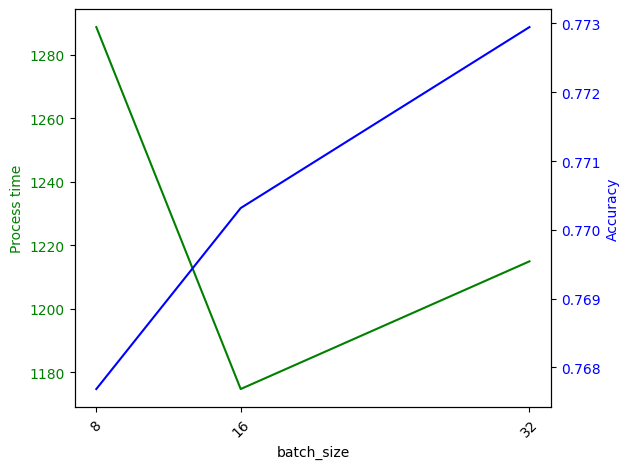

In [ ]:
# Print out and plot result dataframe
print(result_df)
plot_survey(result_df, 'batch_size', 'Process time', 'Accuracy')

#### epoch

In [ ]:
# Initialize survey list and result dataframe
epoch_in = [1, 3, 10]
result_df = pd.DataFrame({
    'epoch': [],
    'Process time': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-score': []
    })

# Model evaluation
for epoch_i in epoch_in:
  # Load pre-trained model
  model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
  # Survey model and return dataframe
  temp_df = re_train(model, new_df, test_ratio=0.4, shuffle=True, batch_size=32, epoch=epoch_i)
  # Append new data to result_df
  result_df = pd.concat([result_df, temp_df], axis=0, ignore_index=True)

result_df['epoch'] = epoch_in

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

   epoch  Process time  Accuracy    Recall  Precision  F1-score
0      1    256.586392  0.751211  0.416995   0.671368  0.514456
1      3    728.933487  0.769071  0.468682   0.701639  0.561975
2     10   2369.249527  0.763118  0.526500   0.656114  0.584204


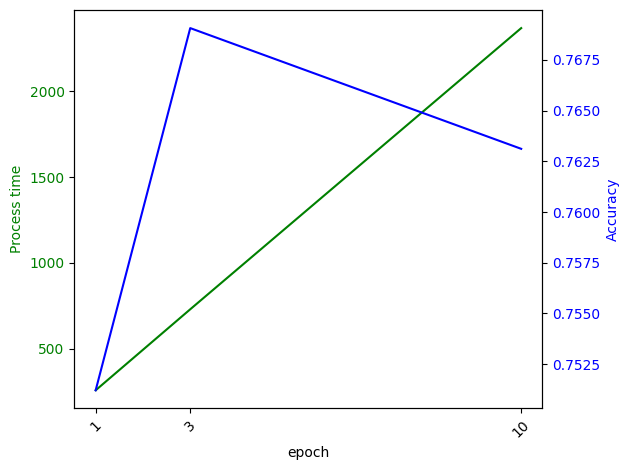

In [ ]:
# Print out and plot result dataframe
print(result_df)
plot_survey(result_df, 'epoch', 'Process time', 'Accuracy')

#### Example on test_ratio

In [ ]:
# Initialize example data from first 20 sentence for testing function "re_train"
temp_data = new_df.iloc[0:20, :]

# Model evaluation with test_ratio
test_ratio_in = [0.1, 0.3, 0.4, 0.6, 0.8]
result_df = pd.DataFrame({
    'test_ratio': [],
    'Process time': [],
    'Accuracy': [],
    'Recall': [],
    'Precision': [],
    'F1-score': []
    })

for test_ratio in test_ratio_in:
  model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
  temp_df = re_train(model, temp_data, test_ratio, shuffle=True, batch_size=32, epoch=5) # 12 train, 8 test

  # Append new data to result_df
  result_df = pd.concat([result_df, temp_df], axis=0, ignore_index=True)

result_df['test_ratio'] = test_ratio_in

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

   test_ratio  Process time  Accuracy    Recall  Precision  F1-score
0         0.1      1.677342    1.0000  1.000000   1.000000  1.000000
1         0.3      1.440688    1.0000  1.000000   1.000000  1.000000
2         0.4      1.340889    0.7500  0.800000   0.800000  0.800000
3         0.6      0.853883    0.7500  0.666667   0.800000  0.727273
4         0.8      0.793877    0.6875  0.625000   0.714286  0.666667


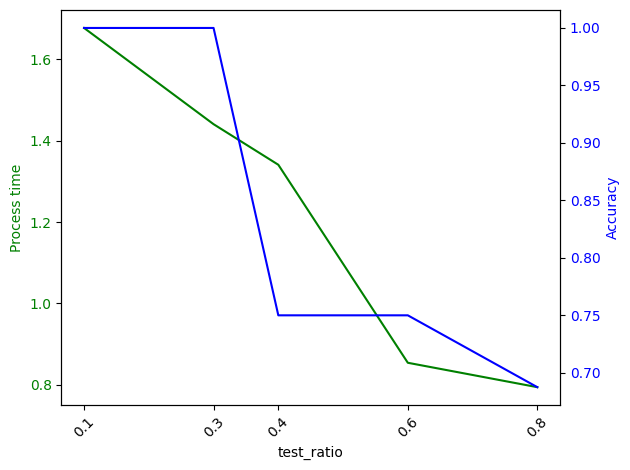

In [ ]:
# Plot
print(result_df)
plot_survey(result_df, 'test_ratio', 'Process time', 'Accuracy')

In [ ]:
# Model evaluation
model = SentenceTransformer('VoVanPhuc/sup-SimCSE-VietNamese-phobert-base')
result_df = re_train(model, new_df, test_ratio=0.4, shuffle=True, batch_size=32, epoch=5) # 10 834 train, 7 222 test

result_df

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

Iteration:   0%|          | 0/339 [00:00<?, ?it/s]

,Accuracy,Recall,Precision,F1-score
0,0.769625,0.497591,0.687235,0.577236
